In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/MIE424

Mounted at /content/drive
/content/drive/MyDrive/MIE424


In [ ]:
!pip install git+https://github.com/DLR-RM/stable-baselines3@feat/gymnasium-support
!pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib@feat/gymnasium-support
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DLR-RM/stable-baselines3 (to revision feat/gymnasium-support) to /tmp/pip-req-build-f3fxt3n_
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-f3fxt3n_
  Running command git checkout -q feat/gymnasium-support
  error: pathspec 'feat/gymnasium-support' did not match any file(s) known to git
  error: subprocess-exited-with-error
  
  × git checkout -q feat/gymnasium-support did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git checkout -q feat/gymnasium-support did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Looking in indexes: https://pypi.org/

In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN, A2C, HerReplayBuffer
from sb3_contrib import ARS, TRPO
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback
import seaborn as sns

class RewardTracker(BaseCallback):
    def __init__(self):
        super(RewardTracker, self).__init__()
        self.rewards = []

    def _on_step(self) -> bool:
        # Get the current episode reward
        if len(self.model.ep_info_buffer) > 0:
            current_reward = self.model.ep_info_buffer[-1]['r']
            if current_reward is not None:
                self.rewards.append(current_reward)
        return True

def train_and_evaluate(algorithms, env_ids, timesteps, plot_title, iters=1):
    results = {env_id: {algo_name: [] for algo_name in algorithms.keys()} for env_id in env_ids}

    for env_id in env_ids:
        env = gym.make(env_id)

        for algo_name, algo_class in algorithms.items():
            print(f"Training {algo_name} on {env_id}...")

            algo_rewards = []
            max_reward_length = 0
            for i in range(iters):
                if algo_name == 'DQN':
                    model = algo_class("MlpPolicy", env, buffer_size=100000, learning_starts=25000, target_update_interval=1000, verbose=0)
                else:
                    model = algo_class("MlpPolicy", env, verbose=0)
                # Train the agent
                reward_tracker = RewardTracker()

                model.learn(total_timesteps=timesteps, callback=reward_tracker)

                rewards_array = np.array(reward_tracker.rewards)
                max_reward_length = max(max_reward_length, len(rewards_array))
                algo_rewards.append(rewards_array)
                print(f"{algo_name} on {env_id} - Iteration {i + 1} Completed")

            for i, rewards_array in enumerate(algo_rewards):
                if len(rewards_array) < max_reward_length:
                    algo_rewards[i] = np.pad(rewards_array, (0, max_reward_length - len(rewards_array)), constant_values=np.nan)

            results[env_id][algo_name] = np.array(algo_rewards)

            print(f"{algo_name} on {env_id} - Training Completed")

        # Close the environments
        env.close()

    # Plot the results
    plt.figure(figsize=(12, 6))

    for i, (env_id, rewards) in enumerate(results.items()):
        plt.subplot(1, len(env_ids), i + 1)

        for algo_name, reward_values in rewards.items():
            mean_rewards = reward_values.mean(axis=0)
            std_rewards = reward_values.std(axis=0)

            sns.lineplot(x=np.arange(len(mean_rewards)), y=mean_rewards, label=algo_name)
            plt.fill_between(np.arange(len(mean_rewards)), mean_rewards - std_rewards, mean_rewards + std_rewards, alpha=0.3)

        plt.xlabel("Training Episodes")
        plt.ylabel("Reward")
        plt.title(f"{env_id} - Reward vs. Training Episodes")
        plt.legend()

    plt.suptitle(plot_title)
    plt.savefig("reward_vs_episodes_{}_just_ARS_smol.png".format(timesteps), dpi=300)
    plt.show()

In [ ]:
!pip install gymnasium[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 40.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 43.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to fix the wheel build issue repo

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'CartPoleJax-v0', 'CartPoleJax-v1', 'PendulumJax-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Jax-Blackjack-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV21Environment-v0', 'GymV26Environment-v0'])
Training ARS on CartPole-v1...
ARS on CartPole-v1 - Iteration 1 Completed
ARS on CartPole-v1 - Training Complet

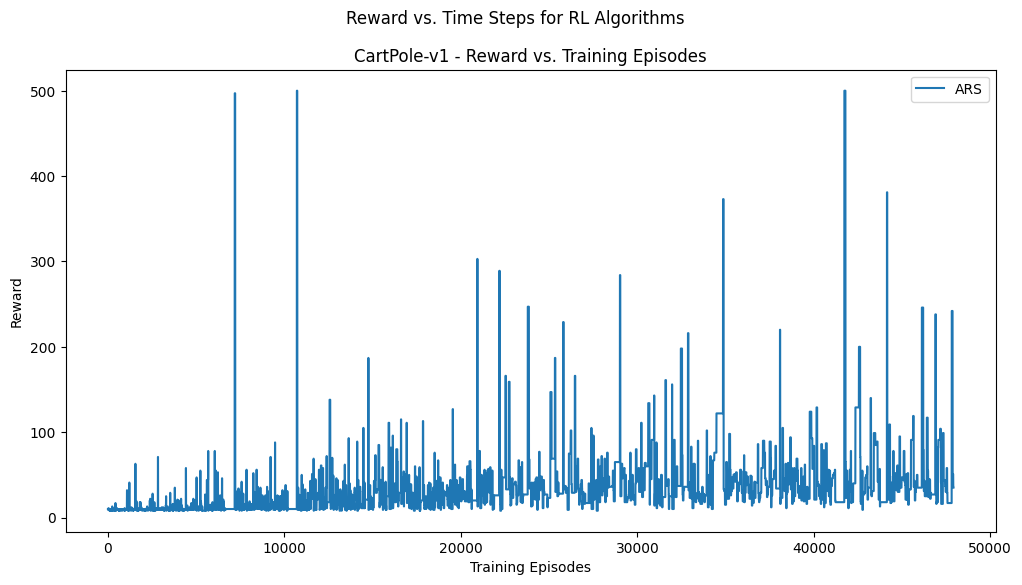

In [ ]:
print(gym.envs.registry.keys())

algorithms = {
    #"DQN": DQN,
    "ARS": ARS,
    #"TRPO": TRPO,
    #"PPO": PPO,
    #"DQN": DQN,
    #"A2C": A2C
}

env_ids = [
    "CartPole-v1",
]

# env_ids = [
#     "Acrobot-v1",
#     "LunarLander-v2",   
# ]
train_and_evaluate(algorithms, env_ids, timesteps=50001, plot_title="Reward vs. Time Steps for RL Algorithms")